In [17]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv, GATConv, GINConv
import pandas as pd
import json
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import os
from community import community_louvain


In [6]:
import json

file_path = "git_web_ml/musae_git_features.json"
with open(file_path, "r") as f:
    features_dict = json.load(f)

N = len(features_dict)
max_index = 0
for feature_list in features_dict.values():
    if len(feature_list) > 0:
        max_index = max(max_index, max(feature_list))


D = max_index + 1
print("Number of nodes N is ->", N)
print("Feature dimension D is ->", D)


Number of nodes N is -> 37700
Feature dimension D is -> 4005


In [9]:
import torch

row_indices = []
col_indices = []

for node_id, feature_list in features_dict.items():
    node = int(node_id)
    for feature_idx in feature_list:
        row_indices.append(node)
        col_indices.append(feature_idx)

values = torch.ones(len(row_indices), dtype=torch.float)
indices = torch.tensor([row_indices, col_indices], dtype=torch.long)
x = torch.sparse_coo_tensor(
    indices,
    values,
    size=(N, D)
)

print("Sparse feature matrix shape:", tuple(x.shape))
print("Number of non-zero entries:", x._nnz())


Sparse feature matrix shape: (37700, 4005)
Number of non-zero entries: 690374


In [11]:
import pandas as pd
import torch

edge_path = "git_web_ml/musae_git_edges.csv"
edges = pd.read_csv(edge_path)
edge_index = torch.tensor(
    edges.values.T,
    dtype=torch.long
)

print("Edge index shape:", tuple(edge_index.shape))
print("Number of edges:", edge_index.shape[1])


Edge index shape: (2, 289003)
Number of edges: 289003


In [12]:
import torch

row = edge_index[0]
degree = torch.bincount(row, minlength=N)
print("Min degree:", degree.min().item())
print("Max degree:", degree.max().item())
print("Average degree:", degree.float().mean().item())


Min degree: 0
Max degree: 6809
Average degree: 7.665862083435059


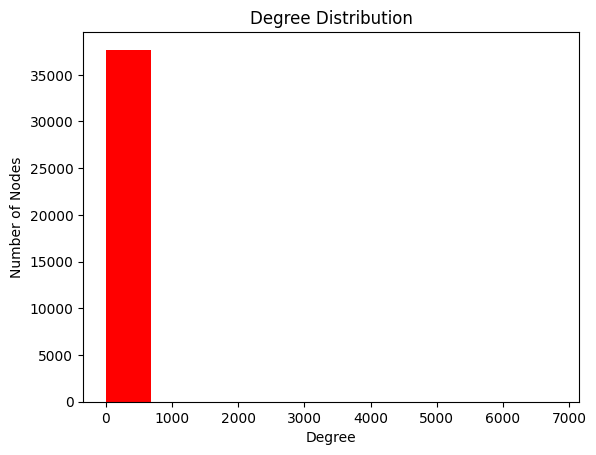

In [13]:
import matplotlib.pyplot as plt

deg_np = degree.numpy()
plt.figure()
plt.hist(deg_np, bins=10, color='red')
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.title("Degree Distribution")
plt.show()



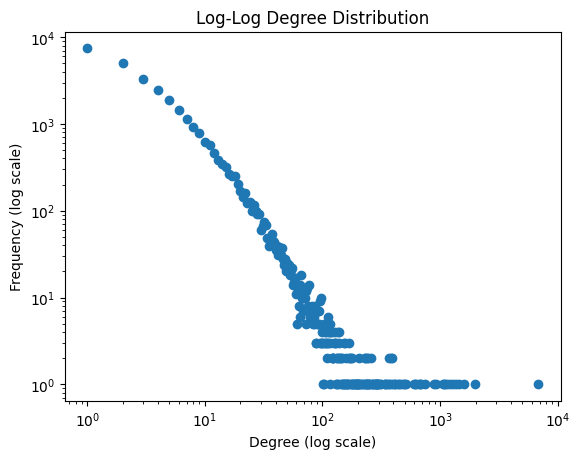

In [14]:
import numpy as np

unique_deg, counts = np.unique(deg_np, return_counts=True)
plt.figure()
plt.loglog(unique_deg, counts, marker='o', linestyle='none')
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Log-Log Degree Distribution")
plt.show()

In [18]:
import networkx as nx
from community import community_louvain

edge_list = edge_index.t().tolist()
G = nx.Graph()
G.add_edges_from(edge_list)

print("Number of nodes in G:", G.number_of_nodes())
print("Number of edges in G:", G.number_of_edges())


Number of nodes in G: 37700
Number of edges in G: 289003


In [19]:
partition = community_louvain.best_partition(G, random_state=42)
community_labels = torch.zeros(N, dtype=torch.long)
unique_comms = sorted(set(partition.values()))
comm_map = {old_id: new_id for new_id, old_id in enumerate(unique_comms)}

for node in range(N):
    community_labels[node] = comm_map[partition[node]]
print("Number of communities:", community_labels.unique().numel())


Number of communities: 31


In [20]:
modularity = community_louvain.modularity(partition, G)
print("Modularity score:", modularity)



Modularity score: 0.4534478734786025


In [22]:
from collections import Counter
import numpy as np

community_sizes = Counter(community_labels.tolist())
sizes = np.array(list(community_sizes.values()), dtype=int)

print("Number of communities:", len(sizes))
print("Min community size:", int(sizes.min()))
print("Max community size:", int(sizes.max()))
print("Mean community size:", float(sizes.mean()))
print("Median community size:", float(np.median(sizes)))
sorted_sizes = sorted([int(x) for x in sizes], reverse=True)
print("Top 5 largest communities:", sorted_sizes[:5])
print("Bottom 5 smallest communities:", sorted_sizes[-5:])


Number of communities: 31
Min community size: 3
Max community size: 8732
Mean community size: 1216.1290322580646
Median community size: 9.0
Top 5 largest communities: [8732, 7664, 6454, 3047, 2702]
Bottom 5 smallest communities: [3, 3, 3, 3, 3]


In [ ]:
for comm_id in community_to_nodes:
    community_to_nodes[comm_id] = torch.tensor(
        community_to_nodes[comm_id],
        dtype=torch.long
    )

for k in list(community_to_nodes.keys())[:3]:
    print(f"Community {k} size:", community_to_nodes[k].shape[0])



Community 0 size: 3047
Community 13 size: 6454
Community 8 size: 2087


In [26]:
import random

community_ids = list(community_to_nodes.keys())

def sample_triplet():
    comm = random.choice(community_ids)
    nodes_in_comm = community_to_nodes[comm]
    if len(nodes_in_comm) < 2:
        return sample_triplet()    
    anchor, positive = random.sample(nodes_in_comm.tolist(), 2)
    neg_comm = random.choice([c for c in community_ids if c != comm])
    negative = random.choice(community_to_nodes[neg_comm].tolist())
    return anchor, positive, negative

In [27]:
a, p, n = sample_triplet()
print("Anchor:", a)
print("Positive:", p)
print("Negative:", n)
print("Anchor community:", community_labels[a].item())
print("Positive community:", community_labels[p].item())
print("Negative community:", community_labels[n].item())

Anchor: 1295
Positive: 31690
Negative: 19496
Anchor community: 7
Positive community: 7
Negative community: 4


In [28]:
from torch_geometric.data import Data


x_dense = x.to_dense()
data = Data(
    x=x_dense,
    edge_index=edge_index
)
print(data)

Data(x=[37700, 4005], edge_index=[2, 289003])


In [29]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()        
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.normalize(x, p=2, dim=1)
        
        return x